In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn import metrics
from scipy.optimize import minimize
from torch import nn, tensor
import pylab
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def generate_ranges(data, xtrue, ytrue, sd, N):
    x_coor = data[['x']].values
    y_coor = data[['y']].values
    ni = np.random.normal(0, sd ** 2, N)
    dTi = np.sqrt((xtrue - x_coor)**2 + (ytrue - y_coor)**2)
    dTi = dTi.reshape((1, N))
    range = dTi + ni
    #resample for any negative values
    range[range < 0] = np.random.normal(0, sd ** 2, np.sum(range < 0))
    return range


In [3]:
def objective_func(pos, data, noise = 0.3):
    """Objective function for the optimization problem.

    Args:
        x (float): the x coordinate
        y (float): the y coordinate
        data (pandas.DataFrame): the data containing the localization information

    Returns:
        float: the objective function value
    """
    x, y = pos
    sumx = 0
    sumy = 0
    for i, ele in data.iterrows():
        dix = x - ele['x']
        diy = y - ele['y']
        sumx += (ele['range'] - dix)** 2 / (2 * noise ** 2)
        sumy += (ele['range'] - diy)** 2 / (2 * noise ** 2)
    
    #not the noise here should be sigmax and sigmay but i am not sure what these should be
    sigmax = .125
    sigmay = .125
    return np.sqrt((sumx + (x**2 / sigmax**2))**2 + (sumy + (y**2 / sigmay**2))**2)


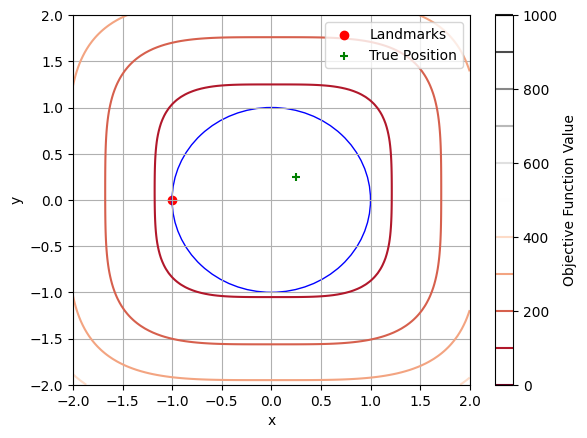

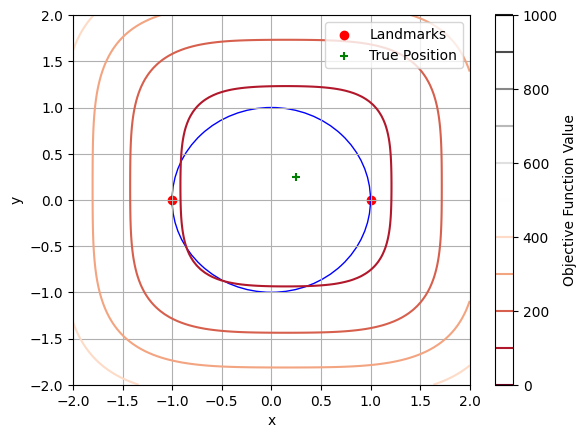

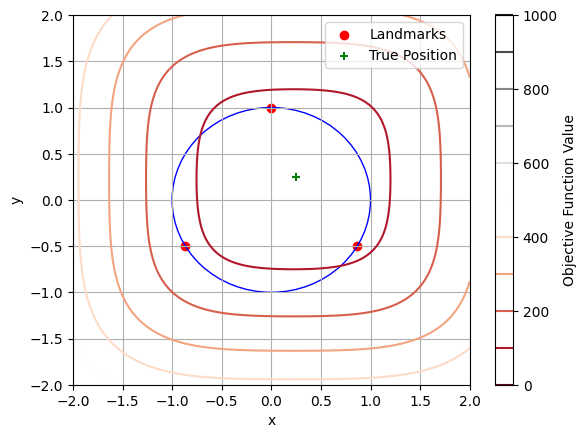

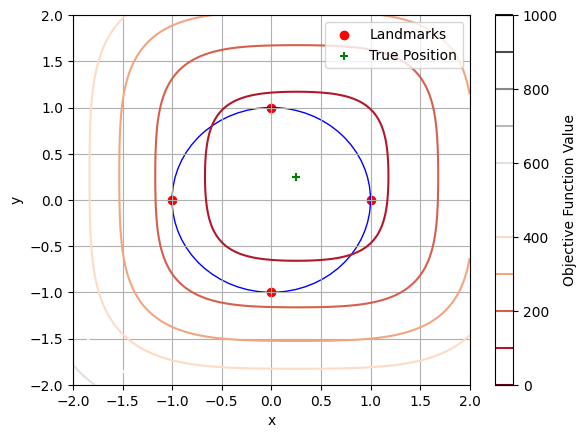

In [4]:
noise_sd = 0.3
xtrue = .25
ytrue = .25


#generate ranges based on the noise and true position
data_landmarks1 = pd.DataFrame([[-1, 0]], columns=['x', 'y'])
data_landmarks2 = pd.DataFrame([[1, 0], [-1, 0]], columns=['x', 'y'])
data_landmarks3 = pd.DataFrame([[0, 1], [-(3)**(1/2)/2, -1/2], [(3)**(1/2)/2, -1/2]], columns=['x', 'y'])
data_landmarks4 = pd.DataFrame([[0, 1], [0, -1], [1, 0], [-1, 0]], columns=['x', 'y'])
list_data_landmarks = [data_landmarks1, data_landmarks2, data_landmarks3, data_landmarks4]

for data_landmarks in list_data_landmarks:
    K = len(data_landmarks)
    ranges = generate_ranges(data_landmarks, xtrue, ytrue, noise_sd, K)
    data = data_landmarks.join(pd.DataFrame(ranges.T, columns=['range']))

    xs = np.linspace(-2, 2, 100)
    ys = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(xs, ys)
    guesses = objective_func([X, Y], data)

    # These are loss values for each point
    #Z = np.column_stack((guesses[0].flatten(), guesses[1].flatten()))
    Z = guesses
    # Plot points 2D
    fig, ax = plt.subplots()
    ax.scatter(data['x'], data['y'], c='r', marker='o', label='Landmarks')

    cont = ax.contour(X, Y, Z, levels=np.linspace(0, 1000, 11), cmap='RdGy')
    circ = plt.Circle((0, 0), 1, color='blue', fill=False)
    plt.scatter(xtrue, ytrue, c='g', marker='+', label='True Position')
    ax.add_patch(circ)

    # Superimpose the true position of the vehicle on these contours using '+'
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(cont)
    cbar.set_label('Objective Function Value')


plt.show()